## Import libraries and user-defined functions

In [1]:
import gc
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from src.loaders.data_loader import load_original_books_dataset
from src.models.linear_models.pca_classifier import pca_classifier
from src.transformers.data_transformer import transform_books_dataset


## Import dataset

In [2]:
original_books_df = load_original_books_dataset()
original_books_df.sample(n=5, random_state=123)


,isbn13,authors,average_rating,publication_year,publisher,num_pages,ratings_count,text_reviews_count
6391,9780439651363,Gordon Korman,4.05,2005,Scholastic Inc.,154,4598,371
628,9780375415029,Raymond Chandler/Tom Hiney,4.45,2002,Everyman's Library,1016,241,11
10,9780739322208,Douglas Adams/Stephen Fry,4.22,2005,Random House Audio,6,1266,253
1001,9780517201664,Colleen McCullough,3.67,1999,Wings,768,39,7
6627,9780812976151,E.L. Doctorow,3.80,2006,Random House Trade Paperbacks,363,8266,831


## Data analysis - Part 1

In [3]:
original_books_df.describe()


,average_rating,publication_year,num_pages,ratings_count,text_reviews_count
count,11127.000000,11127.000000,11127.000000,1.112700e+04,11127.000000
mean,3.933631,2000.167520,336.376921,1.793641e+04,541.854498
std,0.352445,8.248836,241.127305,1.124794e+05,2576.176608
min,0.000000,1900.000000,0.000000,0.000000e+00,0.000000
25%,3.770000,1998.000000,192.000000,1.040000e+02,9.000000
50%,3.960000,2003.000000,299.000000,7.450000e+02,46.000000
75%,4.135000,2005.000000,416.000000,4.993500e+03,237.500000
max,5.000000,2020.000000,6576.000000,4.597666e+06,94265.000000


- Books with 0 values found for 'average_rating', 'num_pages' and 'ratings_count' are likely errors in the data.
- Books with 0 values found for 'average_rating' will be discarded, whereas for 'num_pages' and 'ratings_count' we will try to correct them using scrapping.
- 0 values for 'text_reviews_count' are possible, and won't be taken as errors in the data.
- Having old books (publication_year < 2003) up to 50% in the dataset shows that we aren't just dealing with recent literature.


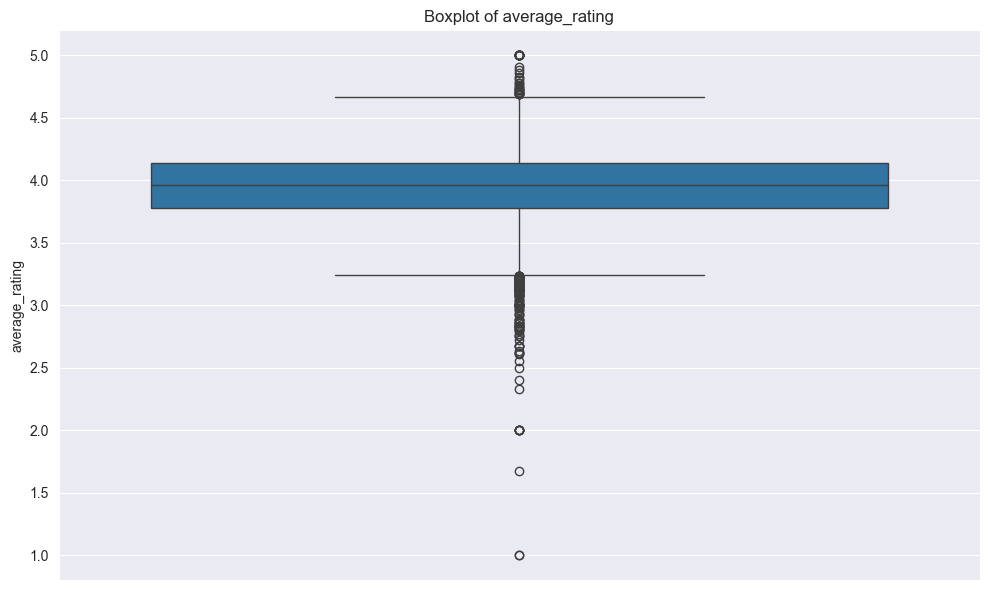

In [4]:
target_name = "average_rating"
mask_valid_books = original_books_df[target_name] != 0
target_df = original_books_df.loc[mask_valid_books, ][[target_name]]

fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=3.0)

sns.boxplot(
    data=target_df,
    y=target_name,
    ax=ax,
)

ax.set_title(f"Boxplot of {target_name}")
ax.set_ylabel(target_name)
ax.set_xlabel("")

plt.tight_layout()
plt.show()


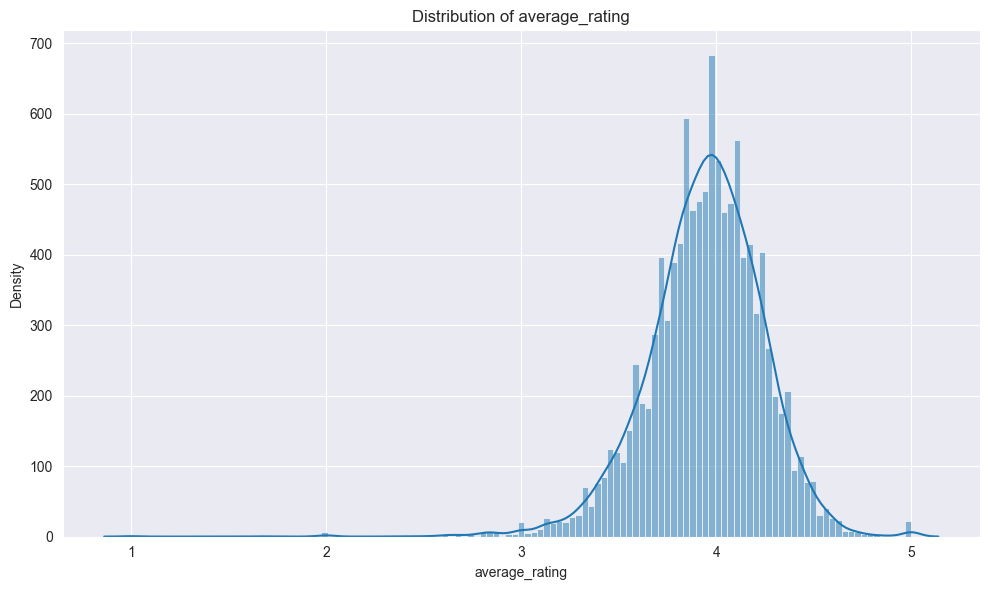

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=3.0)

iqr = stats.iqr(target_df)
bin_width = 2 * iqr / (len(target_df) ** (1/3))
n_bins = int((target_df.max().iloc[0] - target_df.min().iloc[0]) / bin_width)

sns.histplot(
    data=target_df,
    x=target_name,
    kde=True,
    ax=ax,
    bins=n_bins,
    kde_kws={'cut': 3}
)

ax.set_title(f"Distribution of {target_name}")
ax.set_xlabel(target_name)
ax.set_ylabel("Density")

plt.tight_layout()
plt.show()


In [6]:
target_df.describe().T

,count,mean,std,min,25%,50%,75%,max
average_rating,11101.0,3.942844,0.29695,1.0,3.78,3.96,4.14,5.0


- The "average_rating" variable exhibits low variability, as its standard deviation is no greater than 0.3.
- The narrowest range is observed between Q2 and Q3, spanning only up to 0.18. Despite being quite small, this range still contains 25% of the data.
- While the median (3.96) and mean (3.94) are relatively close, suggesting a potentially symmetric distribution, both the boxplot and histogram reveal a left-skewed distribution caused by the presence of books with extremely low ratings.


To simplify the "average_rating" variable, it could be grouped into two categories:
- "Low" (≤3) and "High" (>3), or "Low" (≤4) and "High" (>4), or "Low" (≤3.94) and "High" (>3.94).
- The first two options (cutoffs at 3 and 4) serve as general categorizations.
- The third option (cutoff at 3.94) aligns with the current data distribution and may help address any observed imbalance in the dataset.

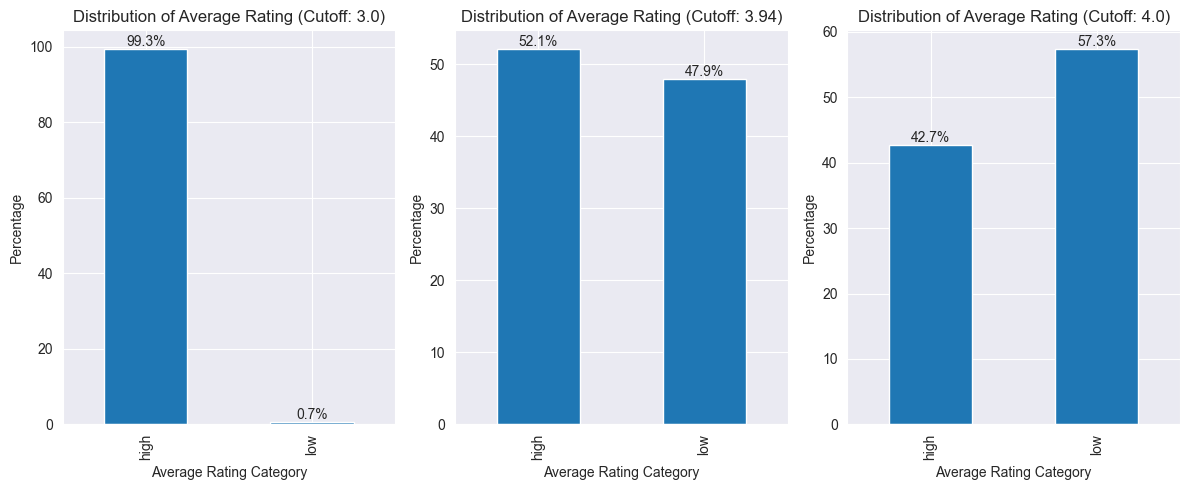

In [7]:
def create_category_and_percentages(df: pd.DataFrame, threshold: float) -> pd.Series:
    df["average_rating_category"] = df["average_rating"].apply(
        lambda x: "low" if x <= threshold else "high"
    )
    category_counts = df["average_rating_category"].value_counts()
    return (category_counts / len(df) * 100).sort_index()

new_target_df = target_df.copy(deep=True)
cutoffs = [3.00, target_df.mean().iloc[0].round(2), 4.00]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

for ax, cutoff in zip([ax1, ax2, ax3], cutoffs):
    category_percentages = create_category_and_percentages(new_target_df, cutoff)

    category_percentages.plot(kind="bar", ax=ax)
    ax.set_title(f"Distribution of Average Rating (Cutoff: {cutoff})")
    ax.set_xlabel("Average Rating Category")
    ax.set_ylabel("Percentage")

    for i, v in enumerate(category_percentages):
        ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


- Dividing "average_rating" into two categories based on the mean (3.94) or the value 4 provides a more balanced distribution of "average_rating," which is beneficial.
- However, we opted not to use 3.94 as the cutoff, as it is heavily influenced by the current data distribution and may not accurately represent future trends.Instead, we believe that setting the cutoff at 4 is a more objective approach.

## Feature engineering

This step can take some time as it involves processing some textual information of book details. Please be patient while running this part.

In [8]:
data = await transform_books_dataset(books_df=original_books_df)


Batches:   0%|          | 0/217 [00:00<?, ?it/s]

In [9]:
print(f"Covariates' number after feature engineering: {data['train']['features']['original'].shape[1]}")


Covariates' number after feature engineering: 10


In [10]:
results = []

for data_type in data.keys():
    features = data[data_type]["features"]

    for features_version in features.keys():
        all_means = features[features_version].mean()
        all_stds = features[features_version].std()
        results.append(
            {
                "data_type": data_type,
                "features_version": features_version,
                "average_min": all_means.min(),
                "average_max": all_means.max(),
                "std_min": all_stds.min(),
                "std_max": all_stds.max(),
            }
        )

print(tabulate(pd.DataFrame(results), headers="keys", tablefmt="pretty", showindex=False))


+-----------+------------------+------------------------+------------------------+--------------------+--------------------+
| data_type | features_version |      average_min       |      average_max       |      std_min       |      std_max       |
+-----------+------------------+------------------------+------------------------+--------------------+--------------------+
|   train   |     original     | -6.584179790827183e-17 | 4.585149648778819e-15  | 1.000064356276412  | 1.0000643562764127 |
|   train   |      noise       | -7.315755323141314e-17 | 1.2835492714451437e-14 | 1.0000643562764122 | 1.0000643562764127 |
|   test    |     original     |  -0.01753921159142752  |  0.04583559784073436   | 0.7133164627578104 | 1.4228938599796255 |
|   test    |      noise       |  -0.01753213647120433  |  0.045835630901794905  | 0.7133187347716701 | 1.4228939067203945 |
+-----------+------------------+------------------------+------------------------+--------------------+--------------------+


In [11]:
del results, data_type
gc.collect()


9526

## Data analysis - Part 2

All our covariates are now all numerical, we can perform an association analysis to understand their relationships with average_rating_category.
The analysis will be done only on the training dataset. The noisy version of features was obtained by adding a simulated white gaussian noise to the original features values.

In [12]:
original_df = data["train"]["features"]["original"].copy(deep=True).reset_index(drop=True)
noise_df = data["train"]["features"]["noise"].copy(deep=True).reset_index(drop=True)
target_df = data["train"]["targets"].reset_index(drop=True)


### _Features original version_

In [13]:
results = []

for feature in original_df.columns:
    for target in target_df.columns:
        feature_data = original_df[feature]
        target_data = target_df[target]

        categories = target_data.unique()

        group1 = feature_data[target_data == categories[0]]
        group2 = feature_data[target_data == categories[1]]

        statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')

        median1 = np.median(group1)
        median2 = np.median(group2)

        results.append({
            'Feature': feature,
            'Target': target,
            'Category 1': categories[0],
            'Category 2': categories[1],
            'Median 1': median1,
            'Median 2': median2,
            'U-statistic': statistic,
            'p-value': p_value
        })

print(tabulate(pd.DataFrame(results), headers="keys", tablefmt="pretty", showindex=False, floatfmt=".4f"))


+-------------------------+-------------------------+------------+------------+----------------------+----------------------+-------------+------------------------+
|         Feature         |         Target          | Category 1 | Category 2 |       Median 1       |       Median 2       | U-statistic |        p-value         |
+-------------------------+-------------------------+------------+------------+----------------------+----------------------+-------------+------------------------+
|    publication_year     | average_rating_category |    low     |    high    |  0.350902400503029   | 0.22940009872457537  |  7719054.5  | 0.00042840044160899227 |
|        num_pages        | average_rating_category |    low     |    high    | -0.20126385321108434 | -0.08669347898138477 |  6636974.0  | 3.9613866659905396e-14 |
|      ratings_count      | average_rating_category |    low     |    high    | -0.1626643053595306  | -0.15949574575508058 |  6773904.0  | 7.228592913973001e-10  |
|   text_r

Features "revisions_count", "publication_year" and "publisher_score" don't display significant association with "average_rating_category" based on a Mann-Whitney U test of 95% of confidence level.

In [14]:
data["train"]["features"]["original"].corr(method="spearman")


,publication_year,num_pages,ratings_count,text_reviews_count,revisions_count,want_to_read_count,currently_reading_count,already_read_count,publisher_score,author_score
publication_year,1.000000,-0.021619,0.119471,0.147009,0.071793,0.053289,0.027503,0.075558,-0.052724,-0.085153
num_pages,-0.021619,1.000000,0.184452,0.167679,-0.004791,0.037586,0.065958,0.042388,0.065921,0.049500
ratings_count,0.119471,0.184452,1.000000,0.958095,0.066001,0.204628,0.190346,0.288158,0.102403,0.143845
text_reviews_count,0.147009,0.167679,0.958095,1.000000,0.070460,0.212867,0.208852,0.289988,0.109926,0.115090
revisions_count,0.071793,-0.004791,0.066001,0.070460,1.000000,0.742990,0.483225,0.603707,0.001184,-0.031217
want_to_read_count,0.053289,0.037586,0.204628,0.212867,0.742990,1.000000,0.738843,0.839510,0.017468,0.089733
currently_reading_count,0.027503,0.065958,0.190346,0.208852,0.483225,0.738843,1.000000,0.709190,0.036246,0.153053
already_read_count,0.075558,0.042388,0.288158,0.289988,0.603707,0.839510,0.709190,1.000000,0.033282,0.168542
publisher_score,-0.052724,0.065921,0.102403,0.109926,0.001184,0.017468,0.036246,0.033282,1.000000,0.088758
author_score,-0.085153,0.049500,0.143845,0.115090,-0.031217,0.089733,0.153053,0.168542,0.088758,1.000000


In [15]:
data["train"]["features"]["original"].corr(method="kendall")


,publication_year,num_pages,ratings_count,text_reviews_count,revisions_count,want_to_read_count,currently_reading_count,already_read_count,publisher_score,author_score
publication_year,1.000000,-0.015149,0.081905,0.101421,0.052884,0.039463,0.021959,0.058165,-0.035922,-0.058693
num_pages,-0.015149,1.000000,0.125025,0.113308,-0.002701,0.027881,0.051628,0.032222,0.045128,0.033574
ratings_count,0.081905,0.125025,1.000000,0.828549,0.048639,0.157819,0.150628,0.228614,0.067938,0.097479
text_reviews_count,0.101421,0.113308,0.828549,1.000000,0.052196,0.163667,0.165372,0.227803,0.073759,0.076877
revisions_count,0.052884,-0.002701,0.048639,0.052196,1.000000,0.590733,0.403345,0.491482,0.001579,-0.023281
want_to_read_count,0.039463,0.027881,0.157819,0.163667,0.590733,1.000000,0.668968,0.750592,0.013152,0.066219
currently_reading_count,0.021959,0.051628,0.150628,0.165372,0.403345,0.668968,1.000000,0.651087,0.028210,0.119505
already_read_count,0.058165,0.032222,0.228614,0.227803,0.491482,0.750592,0.651087,1.000000,0.025048,0.128185
publisher_score,-0.035922,0.045128,0.067938,0.073759,0.001579,0.013152,0.028210,0.025048,1.000000,0.060667
author_score,-0.058693,0.033574,0.097479,0.076877,-0.023281,0.066219,0.119505,0.128185,0.060667,1.000000


Both Spearman and Kendall are showing that features such as "ratings_count", "text_reviews_count", "revisions_count", "currently_reading_count", "already_read_count" and "want_to_read_count" are highly correlated (at least a correlation in absolute value equal or greater than 0.4).

In [16]:
del results


### _Features noisy version_

In [17]:
results = []

for feature in noise_df.columns:
    for target in target_df.columns:
        feature_data = original_df[feature]
        target_data = target_df[target]

        categories = target_data.unique()

        group1 = feature_data[target_data == categories[0]]
        group2 = feature_data[target_data == categories[1]]

        statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')

        median1 = np.median(group1)
        median2 = np.median(group2)

        results.append({
            'Feature': feature,
            'Target': target,
            'Category 1': categories[0],
            'Category 2': categories[1],
            'Median 1': median1,
            'Median 2': median2,
            'U-statistic': statistic,
            'p-value': p_value
        })

print(tabulate(pd.DataFrame(results), headers="keys", tablefmt="pretty", showindex=False, floatfmt=".4f"))


+-------------------------+-------------------------+------------+------------+----------------------+----------------------+-------------+------------------------+
|         Feature         |         Target          | Category 1 | Category 2 |       Median 1       |       Median 2       | U-statistic |        p-value         |
+-------------------------+-------------------------+------------+------------+----------------------+----------------------+-------------+------------------------+
|    publication_year     | average_rating_category |    low     |    high    |  0.350902400503029   | 0.22940009872457537  |  7719054.5  | 0.00042840044160899227 |
|        num_pages        | average_rating_category |    low     |    high    | -0.20126385321108434 | -0.08669347898138477 |  6636974.0  | 3.9613866659905396e-14 |
|      ratings_count      | average_rating_category |    low     |    high    | -0.1626643053595306  | -0.15949574575508058 |  6773904.0  | 7.228592913973001e-10  |
|   text_r

We're having similar results to those of the original features :
"revisions_count", "publication_year" and "publisher_score" don't display significant association with "average_rating_category" based on a Mann-Whitney U test of 95% of confidence level.

In [18]:
del results, target_df, original_df, noise_df
gc.collect()


10

In [19]:
data["train"]["features"]["noise"].corr(method="spearman")


,publication_year,num_pages,ratings_count,text_reviews_count,revisions_count,want_to_read_count,currently_reading_count,already_read_count,publisher_score,author_score
publication_year,1.000000,-0.025707,0.115630,0.143182,0.065877,0.048065,0.019598,0.064265,-0.054108,-0.084483
num_pages,-0.025707,1.000000,0.184398,0.167558,-0.007554,0.041414,0.051272,0.031990,0.065678,0.049590
ratings_count,0.115630,0.184398,1.000000,0.957758,0.066918,0.197907,0.141110,0.245060,0.102381,0.143844
text_reviews_count,0.143182,0.167558,0.957758,1.000000,0.072041,0.204941,0.156177,0.245498,0.109870,0.115024
revisions_count,0.065877,-0.007554,0.066918,0.072041,1.000000,0.670525,0.335960,0.496966,0.002019,-0.029887
want_to_read_count,0.048065,0.041414,0.197907,0.204941,0.670525,1.000000,0.519936,0.665729,0.011211,0.090238
currently_reading_count,0.019598,0.051272,0.141110,0.156177,0.335960,0.519936,1.000000,0.449943,0.023647,0.116379
already_read_count,0.064265,0.031990,0.245060,0.245498,0.496966,0.665729,0.449943,1.000000,0.026530,0.151196
publisher_score,-0.054108,0.065678,0.102381,0.109870,0.002019,0.011211,0.023647,0.026530,1.000000,0.088866
author_score,-0.084483,0.049590,0.143844,0.115024,-0.029887,0.090238,0.116379,0.151196,0.088866,1.000000


In [20]:
data["train"]["features"]["noise"].corr(method="kendall")


,publication_year,num_pages,ratings_count,text_reviews_count,revisions_count,want_to_read_count,currently_reading_count,already_read_count,publisher_score,author_score
publication_year,1.000000,-0.017379,0.076599,0.095026,0.044062,0.031901,0.013082,0.042652,-0.035700,-0.056332
num_pages,-0.017379,1.000000,0.124549,0.112374,-0.004501,0.028245,0.034112,0.021417,0.044710,0.033505
ratings_count,0.076599,0.124549,1.000000,0.823163,0.046043,0.140678,0.095860,0.172580,0.067705,0.097356
text_reviews_count,0.095026,0.112374,0.823163,1.000000,0.049537,0.144603,0.105857,0.170381,0.073149,0.076394
revisions_count,0.044062,-0.004501,0.046043,0.049537,1.000000,0.462354,0.225807,0.336227,0.002060,-0.020921
want_to_read_count,0.031901,0.028245,0.140678,0.144603,0.462354,1.000000,0.374187,0.486919,0.008058,0.061401
currently_reading_count,0.013082,0.034112,0.095860,0.105857,0.225807,0.374187,1.000000,0.315317,0.015859,0.078149
already_read_count,0.042652,0.021417,0.172580,0.170381,0.336227,0.486919,0.315317,1.000000,0.017712,0.101983
publisher_score,-0.035700,0.044710,0.067705,0.073149,0.002060,0.008058,0.015859,0.017712,1.000000,0.060576
author_score,-0.056332,0.033505,0.097356,0.076394,-0.020921,0.061401,0.078149,0.101983,0.060576,1.000000


- Results showed by Spearman and Kendall correlations are similar to those obtained with the original features version.
- Using PCA to dissolve these correlations would be a great move before introducing them into a model.

In [21]:
gc.collect()

10

### _Target_

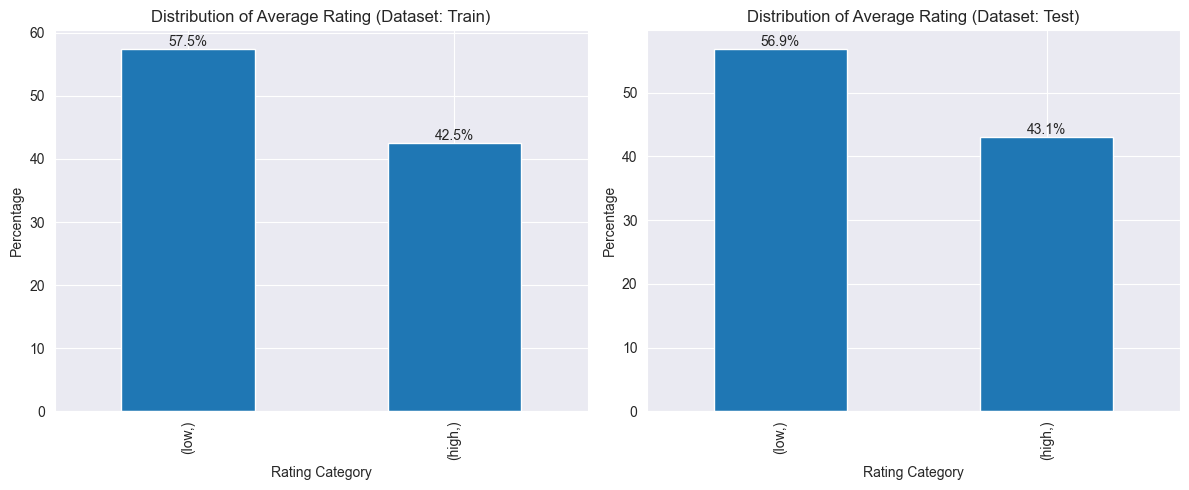

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (dataset_type, dataset) in enumerate(data.items()):
    ax = axes[idx]
    target_df = dataset["targets"]

    category_percentages = target_df.value_counts() / len(target_df) * 100

    category_percentages.plot(kind="bar", ax=ax)
    ax.set_title(f"Distribution of Average Rating (Dataset: {dataset_type.capitalize()})")
    ax.set_xlabel("Rating Category")
    ax.set_ylabel("Percentage")

    for i, v in enumerate(category_percentages):
        ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


The distribution of the target "average_rating_category" shows similarity across all datasets.

## Launch MLflow server to record some experiments

We will run some MLflow experiments locally. Before going any further from the section `pca + logistic regression`, don't forget to start your local server with commands such as : `mlflow server --host localhost --port 9999`.

You can change the server uri and port according to your setup.

In [23]:
mlflow.set_tracking_uri("http://localhost:9999")


In our predictions, we will prioritize identify accurately books with an average rating higher than 4 (high-quality books), as we believe recommending high-quality books to users is essential. At the same time, we do not want to classify too much high quality books as bad ones since they contain interesting information for readers.

To achieve this, we will recode high-quality books as 1 and low-quality books as 0. Additionally, we will use ROC AUC, recall  and precision score as evaluation metrics to assess the performance of our predictions.


In [24]:
new_train_target_df = data["train"]["targets"].copy(deep=True)
new_train_target_df = pd.DataFrame(
    new_train_target_df["average_rating_category"].apply(lambda x: 1 if x == "low" else 0).map(int), columns=["average_rating_category"]
)
data["train"]["targets"]["average_rating_category"] = new_train_target_df.copy(deep=True)

new_test_target_df = data["test"]["targets"].copy(deep=True)
new_test_target_df = pd.DataFrame(
    new_test_target_df["average_rating_category"].apply(lambda x: 1 if x == "low" else 0).map(int), columns=["average_rating_category"]
)
data["test"]["targets"]["average_rating_category"] = new_test_target_df.copy(deep=True)

del new_train_target_df, new_test_target_df

## Linear models

### pca + logistic regression

We're training a regularized logistic regression (L1, L2 penalty) on PCA components for both original and noisy features.

In [25]:
training_pca_results = {
    "original": pca_classifier(
    features_df=data["train"]["features"]["original"],
    targets_df=data["train"]["targets"],
    operation_mode="train",
    ),
    "noise": pca_classifier(
    features_df=data["train"]["features"]["noise"],
    targets_df=data["train"]["targets"],
    operation_mode="train",
    )
}

C:\Users\pfaco\.conda\envs\book_rating_predictor\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
C:\Users\pfaco\.conda\envs\book_rating_predictor\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\pfaco\.conda\envs\book_rating_predictor\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
C:\Users\pfaco\.conda\envs\book_rating_predictor\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [26]:
test_pca_results = {
    "original": pca_classifier(
        features_df=data["test"]["features"]["original"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        modeling_results=training_pca_results["original"],
    ),
    "noise": pca_classifier(
        features_df=data["test"]["features"]["noise"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        modeling_results=training_pca_results["noise"],
    ),
}


In [27]:
pca_perfs = []

for target_name in data["train"]["targets"].columns:
    for version in ["original", "noise"]:
        pca_perfs.append(
            {
                "Target": target_name,
                "Features version": version,

                "Train precision": f"{training_pca_results[version][target_name]['train_precision']:.3f}",
                "Train roc_auc": f"{training_pca_results[version][target_name]['train_roc_auc']:.3f}",
                "Train recall": f"{training_pca_results[version][target_name]['train_recall']:.3f}",

                "Validation precision": f"{training_pca_results[version][target_name]['val_precision']:.3f}",
                "Validation roc_auc": f"{training_pca_results[version][target_name]['val_roc_auc']:.3f}",
                "Validation recall": f"{training_pca_results[version][target_name]['val_recall']:.3f}",

                "Test precision": f"{test_pca_results[version][target_name]['test_precision']:.3f}",
                "Test roc_auc": f"{test_pca_results[version][target_name]['test_roc_auc']:.3f}",
                "Test recall": f"{test_pca_results[version][target_name]['test_recall']:.3f}",

            }
        )

pca_perfs_df = pd.DataFrame(pca_perfs)
pca_perfs_df


,Target,Features version,Train precision,Train roc_auc,Train recall,Validation precision,Validation roc_auc,Validation recall,Test precision,Test roc_auc,Test recall
0,average_rating_category,original,0.606,0.569,0.919,0.606,0.564,0.919,0.604,0.566,0.924
1,average_rating_category,noise,0.606,0.569,0.919,0.606,0.564,0.919,0.604,0.566,0.923


- No overfitting case was discovered for original or noisy features during model training.
- Noisy features aren't doing specially better in terms of recall, precision and roc_auc on the test set compared to the original features, so we won't proceed further with them.


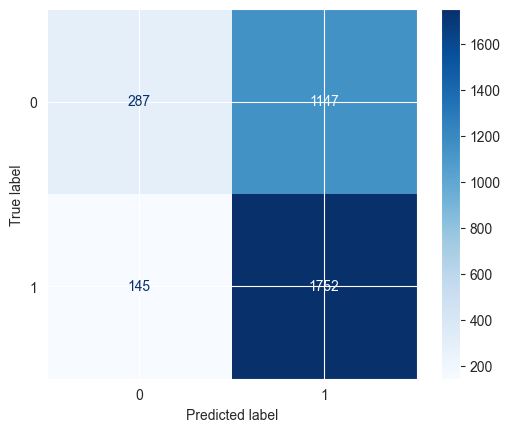

In [28]:
ConfusionMatrixDisplay.from_predictions(
    y_true=data["test"]["targets"]["average_rating_category"],
    y_pred=training_pca_results["original"]["average_rating_category"]["model"].predict(data["test"]["features"]["original"]),
    cmap='Blues',
)
plt.show()


The model is able to remember well most of "high" quality books'  characteristics, still in final "high" books predicted there are at least 40% which are misclassified. We will be focused on improving both recall and precision.

### pca + decision tree

In [29]:
gc.collect()

50